# Mineral NER using Data Programming

Project:: Mars Target Encyclopedia


This notebook does not explain much, however, the exaplanations are found in the original notebook(s) https://github.com/HazyResearch/snorkel/tree/master/tutorials/intro 


## Setup:
1. Follow instructions in https://github.com/HazyResearch/snorkel
2. Start jupyter notebook server using `./run.sh` as described in snorkel README
3. copy this notebook to a place accessible from the jupyter server started in previous step. Perhaps symlink your directory



In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
import os
import numpy as np
import re
import codecs

os.environ['SNORKELDB'] = 'sqlite:///snorkel-mte.db'

In [3]:
# Open Session
session = SnorkelSession()

In [4]:
# Read input
base_dir = '/Users/thammegr/work/mte/data/newcorpus/MTE-corpus-open/'
def scan_docs(dir):
    txt_filter = lambda _: re.match("^[0-9]{4}\.txt$", _)
    for root, dirs, files in os.walk(dir):
        for f in filter(txt_filter, files):
            txt_path = os.path.join(root, f)
            ann_path = txt_path.replace('.txt', '.ann')
            parts = ann_path.split(os.path.sep)
            parts[-2] += "-reviewed-target" # directory name
            new_ann_path = os.path.sep.join(parts)
            if os.path.exists(new_ann_path):
                ann_path = new_ann_path
            yield (txt_path, ann_path)

corpus_file = "mte-corpus.list"
with open(corpus_file, 'w') as f:
    count = 0
    for rec in scan_docs(base_dir):
        f.write(",".join(rec))
        f.write("\n")
        count += 1
    print("Wrote %d records to %s" %(count, corpus_file))

Wrote 5959 records to mte-corpus.list


In [67]:
# sample 100 docs to setup whole pipeline first

!head -30 mte-corpus.list > mte-corpus-head.list
corpus_file = "mte-corpus-head.list"
!wc -l *.list

      30 mte-corpus-head.list
    5959 mte-corpus.list
      10 paths-sample.list
      10 sample-pdfs.list
    1499 wikipedia-minerals.list
    7508 total


In [ ]:
from snorkel.parser import CSVPathsPreprocessor

doc_preprocessor = CSVPathsPreprocessor(path=corpus_file, column=0, delim=',')
#doc_preprocessor = CSVPathsPreprocessor("paths-sample.list")

# Corpus parser to get features
from snorkel.parser import CorpusParser
corpus_parser = CorpusParser()
%time corpus_parser.apply(doc_preprocessor)

In [68]:
from snorkel.models import Document, Sentence

print "Documents:", session.query(Document).count()
print "Sentences:", session.query(Sentence).count()

Documents: 30
Sentences: 1801


In [6]:
# Schema for Minerals
from snorkel.models import candidate_subclass
Mineral = candidate_subclass('Mineral', ['name'])

In [7]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import RegexMatchEach

mineral_matcher = RegexMatchEach(attrib='pos_tags', rgx="NN.*")

ngrams         = Ngrams(n_max=3)
cand_extractor = CandidateExtractor(Mineral, 
                                    [ngrams], [mineral_matcher],
                                    symmetric_relations=False)

In [8]:
# Counts number of nouns in a sentence => could be used for filtering
def number_of_nouns(sentence):
    active_sequence = False
    count = 0
    last_tag = ''
    for tag in sentence.pos_tags:
        if tag.startswith('NN') and not active_sequence:
            active_sequence = True
            count += 1
        elif not tag.startswith('NN') and active_sequence:
            active_sequence = False
    return count

In [9]:
from snorkel.models import Document

# load, filter and split the sentences
docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_sents = set()
dev_sents   = set()
test_sents  = set()
splits = (0.9, 0.95)
for i,doc in enumerate(docs):
    for s in doc.sentences:
        if number_of_nouns(s) > 0:
            if i < splits[0] * ld:
                train_sents.add(s)
            elif i < splits[1] * ld:
                dev_sents.add(s)
            else:
                test_sents.add(s)

In [10]:
s1 = session.query(Sentence).all()[26]
s1.pos_tags

[u'-LRB-',
 u'CD',
 u'-RRB-',
 u'NNP',
 u',',
 u'NNP',
 u'NNP',
 u'FW',
 u'FW',
 u'-LRB-',
 u'CD',
 u'-RRB-',
 u',',
 u'NNP',
 u',',
 u'CD',
 u'.']

In [11]:
cand_extractor.apply(train_sents, split=0)

Clearing existing...
Running UDF...
[========================================] 100%



In [12]:
train_cands = session.query(Mineral).filter(Mineral.split == 0).all()
print "Number of candidates:", len(train_cands)

Number of candidates: 8962


In [13]:
# inspect the candidates using this widget
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(train_cands[:300], session)
sv

<IPython.core.display.Javascript object>

In [14]:
# Develop and Tests
## Develop and Test

for i, sents in enumerate([dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i+1)
    print "Number of candidates:", session.query(Mineral).filter(Mineral.split == i+1).count()

Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 922
Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 401


## Labelling functions

In [165]:
# Distance supervision
minerals_file = "/Users/thammegr/work/mte/git/ref/minerals.txt"
non_minerals_file = "/Users/thammegr/work/mte/git/ref/non-minerals.txt"

def load_set(path, lower=True):
    with codecs.open(path, 'r', 'utf-8') as f:
        lines = f.readlines()
        lines = map(lambda x: x.strip(), lines)
        lines = filter(lambda x: x and not x.startswith('#'), lines)
        if lower:
            lines = map(lambda x: x.lower(), lines)
        return set(lines)

mte_minerals = load_set(minerals_file)
non_minerals = load_set(non_minerals_file)

def lf_dict_mte_minerals(c):
    return 1 if c.name.get_span().lower() in mte_minerals else 0

def lf_dict_nonminerals(c):
    return -1 if c.name.get_span().lower() in non_minerals else 0

# rule based
def lf_rule_ite_minerals(c):
    return 1 if c.name.get_span().lower().endswith('ite') else 0

# rule based 2
ends_ite = re.compile("^[a-z]*[aeiou][a-z]*ite$") 
def lf_rule_ite2_minerals(c): 
    # has one vowel before ite
    return 1 if ends_ite.match(c.name.get_span().lower()) is not None else 0



## Distant supervision

### Get list of known minerals for distant supervision

In [12]:
import requests
from lxml import etree
# lxml supports XPath 1.0 which doesnt have regex match function, so extending it
ns = etree.FunctionNamespace(None)
def matches(dummy, val, patrn):
    if not val:
        return False
    return re.match(patrn, str(val[0])) is not None
ns['matches'] = matches

all_minerals_page = "https://en.wikipedia.org/wiki/List_of_minerals"
tree = etree.HTML(requests.get(all_minerals_page).text)
minerals = tree.xpath('//h2[matches(span/@id, "^[A-Z]$")]/following-sibling::*//li/a/@title')

minerals = set(map(lambda x: x.lower().strip(), minerals)) # remove duplicates
print("Found %d minerals in %s" %(len(minerals), all_minerals_page))

minerals_kb = "wikipedia-minerals.list"
with codecs.open(minerals_kb, 'w', 'utf-8') as out:
    out.write(u"\n".join(minerals))
    print("Stored the mineral names at %s" % minerals_kb)

Found 1500 minerals in https://en.wikipedia.org/wiki/List_of_minerals
Stored the mineral names at wikipedia-minerals.list


In [197]:
minerals_kb = "wikipedia-minerals.list"
minerals_set = load_set(minerals_kb)
def lf_dict_wikipedia_minerals(c):
    return 1 if c.name.get_span().lower() in minerals_set else 0
    # returning 0 instead of -1, because the wikipedia page may not be an exhaustive list.
    # TODO: check with Kiri to confirm this

In [162]:
# Debugging label functions
from pprint import pprint

labeled = []
for c in session.query(Mineral).filter(Mineral.split == 0).all():
    if lf_rule_ite2_minerals(c) != 0: # function 
        labeled.append(c)

print "Number labeled:", len(labeled)


Number labeled: 56


In [139]:
labeled[0]

Mineral(Span("bronzite", sentence=159, chars=[230,237], words=[41,41]))

In [198]:
# all labeling functions in a list
LFs = [
    lf_dict_mte_minerals, lf_dict_nonminerals,
    lf_dict_wikipedia_minerals,
    #lf_rule_ite_minerals,
    lf_rule_ite2_minerals
]

In [199]:
from snorkel.annotations import LabelAnnotator
import numpy as np
labeler = LabelAnnotator(f=LFs)

In [201]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 31.9 s, sys: 143 ms, total: 32 s
Wall time: 32 s


<8962x4 sparse matrix of type '<type 'numpy.float64'>'
	with 138 stored elements in Compressed Sparse Row format>

In [202]:
# Loading it again  -- resume from here
L_train = labeler.load_matrix(session, split=0)
L_train

<8962x4 sparse matrix of type '<type 'numpy.float64'>'
	with 138 stored elements in Compressed Sparse Row format>

In [170]:
L_train.get_candidate(session, 0)

Mineral(Span("radar", sentence=796, chars=[10,14], words=[3,3]))

In [171]:
L_train.get_key(session, 0) 

LabelKey (lf_dict_mte_minerals)

In [203]:
L_train.lf_stats(session, )

,j,Coverage,Overlaps,Conflicts
lf_dict_mte_minerals,0,0.003236,0.002566,0.000000
lf_dict_nonminerals,1,0.001785,0.001785,0.001785
lf_dict_wikipedia_minerals,2,0.006137,0.003905,0.000000
lf_rule_ite2_minerals,3,0.004240,0.003124,0.001785


# Fitting the generative models

In [204]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

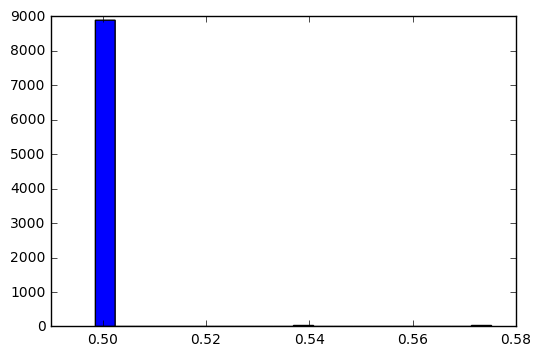

In [191]:
train_marginals = gen_model.marginals(L_train)
# visualize 
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [205]:
gen_model.weights.lf_accuracy()

array([ 0.51871666,  0.51860755,  0.5187    ,  0.51880248])

In [206]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [177]:
L_dev

<922x5 sparse matrix of type '<type 'numpy.float64'>'
	with 256 stored elements in Compressed Sparse Row format>

## Label development set for evaluation

In [7]:
dev_cands = session.query(Mineral).filter(Mineral.split == 1).all()
len(dev_cands)

NameError: name 'Mineral' is not defined

In [72]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(dev_cands, session)
sv

<IPython.core.display.Javascript object>

In [ ]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name=os.environ['USER'], split=1)
L_gold_dev

In [209]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.803
Neg. class accuracy: 0.991
Precision            0.933
Recall               0.803
F1                   0.863
----------------------------------------
TP: 98 | FP: 7 | TN: 793 | FN: 24



In [1]:
fn

NameError: name 'fn' is not defined

In [163]:
L_dev.lf_stats(session, L_gold_dev, gen_model.weights.lf_accuracy())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
lf_dict_mte_minerals,0,0.067245,0.060738,0.000000,58,4,0,0,0.935484,0.519071
lf_dict_nonminerals,1,0.005423,0.005423,0.005423,0,0,0,5,1.000000,0.518340
lf_dict_wikipedia_minerals,2,0.106291,0.099783,0.000000,92,6,0,0,0.938776,0.519468
lf_rule_minerals,3,0.057484,0.044469,0.005423,37,16,0,0,0.698113,0.519274


In [211]:
# Save labels
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 8962 training marginals
CPU times: user 6.16 s, sys: 164 ms, total: 6.33 s
Wall time: 6.35 s


## Part 5: 

### Automatic features


In [212]:
# generate features 
from snorkel.annotations import FeatureAnnotator
featurizer = FeatureAnnotator()
%time F_train = featurizer.apply(split=0)
F_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 3min 43s, sys: 2.26 s, total: 3min 45s
Wall time: 3min 46s


<8962x182754 sparse matrix of type '<type 'numpy.float64'>'
	with 457657 stored elements in Compressed Sparse Row format>

In [213]:
%%time
F_dev  = featurizer.apply_existing(split=1)
F_test = featurizer.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 46.4 s, sys: 768 ms, total: 47.1 s
Wall time: 47 s


In [229]:
from snorkel.learning import SparseLogisticRegression
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# our discriminative model
disc_model = SparseLogisticRegression()

#Hyper parameters search
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)
searcher = RandomSearch(session, disc_model, F_train, train_marginals, [rate_param, l1_param, l2_param], n=20)

from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

# fit 
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.9, print_freq=25)

Initialized RandomSearch search of size 20. Search space size = 125.
[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=79  #epochs=50  batch size=79
[SparseLR] Epoch 0 (5.32s)	Avg. loss=0.917868	NNZ=182754
[SparseLR] Epoch 25 (6.29s)	Avg. loss=0.696658	NNZ=182754
[SparseLR] Epoch 49 (7.21s)	Avg. loss=0.684836	NNZ=182754
[SparseLR] Training done (7.21s)
[SparseLR] Model saved. To load, use name
		SparseLR_0
[2] Testing lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-03
[SparseLR] lr=0.0001 l1=1e-06 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=79  #epochs=50  batch size=79
[SparseLR] Epoch 0 (0.68s)	Avg. loss=0.745201	NNZ=182754
[SparseLR] Epoch 25 (1.61s)	Avg. loss=0.732160	NNZ=182754
[SparseLR] Epoch 49 (2.56s)	Avg. loss=0.722308	NNZ=182754
[SparseLR] Training done (2.56s)
[3] Testing lr = 1.00e-03, l1_penalty

,lr,l1_penalty,l2_penalty,Prec.,Rec.,F1
0,0.010000,0.001000,0.000100,0,0,0
1,0.000100,0.000001,0.001000,0,0,0
18,0.000010,0.010000,0.000001,0,0,0
17,0.010000,0.000010,0.000001,0,0,0
16,0.000001,0.010000,0.001000,0,0,0
15,0.000010,0.000001,0.000100,0,0,0
14,0.000100,0.010000,0.000010,0,0,0
13,0.001000,0.000010,0.000100,0,0,0
12,0.000100,0.000100,0.000010,0,0,0
11,0.001000,0.000001,0.001000,0,0,0


In [228]:
#from snorkel.annotations import load_gold_labels
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
#_, _, _, _ = disc_model.score(session, F_test, L_gold_test)
tp, fp, tn, fn = disc_model.score(session, F_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 0.601
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 368 | TN: 554 | FN: 0



In [226]:
vars(F_dev[0])

{'_shape': (1, 182754),
 'annotation_key_cls': None,
 'candidate_index': None,
 'col_index': None,
 'data': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'indices': array([    2,    34,    38,    89,    91,   126,   140,   156,   495,
          497,  2697,  3108,  3894,  4317,  5709,  5710,  5734, 28157,
        28175, 30053, 37762, 61472, 61478, 73478, 73479, 77022], dtype=int32),
 'indptr': array([ 0, 26], dtype=int32),
 'key_index': None,
 'maxprint': 50,
 'row_index': None}